In [1]:
"""
https://github.com/ankonzoid/Deep-Reinforcement-Learning-Tutorials/blob/master/multiarmed_bandit/multiarmed_bandit.py
 multiarmed_bandit.py  (author: Anson Wong / git: ankonzoid)
 We solve the multi-armed bandit problem using a classical epsilon-greedy
 agent with reward-average sampling to estimate the action-value Q.
 This algorithm follows closely with the notation of Sutton's RL textbook.
 We set up up bandits with a fixed probability distribution of success,
 and receive stochastic rewards from the bandits of +1 for success,
 and 0 reward for failure.
 The update rule for our action-values Q is:
   Q(a) <- Q(a) + 1/(k+1) * (R(a) - Q(a))
 where
   Q(a) = current value estimate of action "a"
   k = number of times action "a" was chosen so far
   R(a) = reward of sampling action bandit (bandit) "a"
 The derivation of the above Q incremental implementation update:
   Q(a;k+1)
   = 1/(k+1) * (R(a_1) + R(a_2) + ... + R(a_k) + R(a))
   = 1/(k+1) * (k*Q(a;k) + R(a))
   = 1/(k+1) * ((k+1)*Q(a;k) + R(a) - Q(a;k))
   = Q(a;k) + 1/(k+1) * (R(a) - Q(a;k))
"""
import numpy as np
import matplotlib.pyplot as plt

def main():
    # =========================
    # Settings
    # =========================
    bandit_probs = [0.10, 0.50, 0.60, 0.80, 0.10,
                    0.25, 0.60, 0.45, 0.75, 0.65]  # bandit probabilities of success
    N_experiments = 2000  # number of experiments to perform
    N_episodes = 10000  # number of episodes per experiment
    epsilon = 0.1  # probability of random exploration (fraction)
    save_fig = False # if false -> plot, if true save as file in same directory
    save_format = ".png"  # ".pdf" or ".png"

    # =========================
    # Define Bandit and Agent class
    # =========================
    class Bandit:
        def __init__(self, bandit_probs):
            self.N = len(bandit_probs)  # number of bandits
            self.prob = bandit_probs  # success probabilities for each bandit

        # Get reward (1 for success, 0 for failure)
        def get_reward(self, action):
            rand = np.random.random()  # [0.0,1.0)
            reward = 1 if (rand < self.prob[action]) else 0
            return reward

    class Agent:
        def __init__(self, bandit, epsilon):
            self.epsilon = epsilon
            self.k = np.zeros(bandit.N, dtype=np.int)  # number of times action was chosen
            self.Q = np.zeros(bandit.N, dtype=np.float)  # estimated value

        # Update Q action-value using:
        # Q(a) <- Q(a) + 1/(k+1) * (r(a) - Q(a))
        def update_Q(self, action, reward):
            self.k[action] += 1  # update action counter k -> k+1
            self.Q[action] += (1./self.k[action]) * (reward - self.Q[action])

        # Choose action using an epsilon-greedy agent
        def choose_action(self, bandit, force_explore=False):
            rand = np.random.random()  # [0.0,1.0)
            if (rand < self.epsilon) or force_explore:
                action_explore = np.random.randint(bandit.N)  # explore random bandit
                return action_explore
            else:
                #action_greedy = np.argmax(self.Q)  # exploit best current bandit
                action_greedy = np.random.choice(np.flatnonzero(self.Q == self.Q.max()))
                return action_greedy

    # =========================
    # Define an experiment
    # =========================
    def experiment(agent, bandit, N_episodes):
        action_history = []
        reward_history = []
        for episode in range(N_episodes):
            # Choose action from agent (from current Q estimate)
            action = agent.choose_action(bandit)
            # Pick up reward from bandit for chosen action
            reward = bandit.get_reward(action)
            # Update Q action-value estimates
            agent.update_Q(action, reward)
            # Append to history
            action_history.append(action)
            reward_history.append(reward)
        return (np.array(action_history), np.array(reward_history))

    # =========================
    #
    # Start multi-armed bandit simulation
    #
    # =========================
    N_bandits = len(bandit_probs)
    print("Running multi-armed bandits with N_bandits = {} and agent epsilon = {}".format(N_bandits, epsilon))
    reward_history_avg = np.zeros(N_episodes)  # reward history experiment-averaged
    action_history_sum = np.zeros((N_episodes, N_bandits))  # sum action history
    for i in range(N_experiments):
        bandit = Bandit(bandit_probs)  # initialize bandits
        agent = Agent(bandit, epsilon)  # initialize agent
        (action_history, reward_history) = experiment(agent, bandit, N_episodes)  # perform experiment

        if (i + 1) % (N_experiments / 20) == 0:
            print("[Experiment {}/{}]".format(i + 1, N_experiments))
            print("  N_episodes = {}".format(N_episodes))
            print("  bandit choice history = {}".format(
                action_history + 1))
            print("  reward history = {}".format(
                reward_history))
            print("  average reward = {}".format(np.sum(reward_history) / len(reward_history)))
            print("")
        # Sum up experiment reward (later to be divided to represent an average)
        reward_history_avg += reward_history
        # Sum up action history
        for j, (a) in enumerate(action_history):
            action_history_sum[j][a] += 1

    reward_history_avg /= np.float(N_experiments)
    print("reward history avg = {}".format(reward_history_avg))

    # =========================
    # Plot reward history results
    # =========================
    plt.plot(reward_history_avg)
    plt.xlabel("Episode number")
    plt.ylabel("Rewards collected".format(N_experiments))
    plt.title("Bandit reward history averaged over {} experiments (epsilon = {})".format(N_experiments, epsilon))
    ax = plt.gca()
    ax.set_xscale("log", nonposx='clip')
    plt.xlim([1, N_episodes])
    if save_fig:
        output_file = "results/MAB_rewards" + save_format
        plt.savefig(output_file, bbox_inches="tight")
    else:
        plt.show()

    # =========================
    # Plot action history results
    # =========================
    plt.figure(figsize=(18, 12))
    for i in range(N_bandits):
        action_history_sum_plot = 100 * action_history_sum[:,i] / N_experiments
        plt.plot(list(np.array(range(len(action_history_sum_plot)))+1),
                 action_history_sum_plot,
                 linewidth=5.0,
                 label="Bandit #{}".format(i+1))
    plt.title("Bandit action history averaged over {} experiments (epsilon = {})".format(N_experiments, epsilon), fontsize=26)
    plt.xlabel("Episode Number", fontsize=26)
    plt.ylabel("Bandit Action Choices (%)", fontsize=26)
    leg = plt.legend(loc='upper left', shadow=True, fontsize=26)
    ax = plt.gca()
    ax.set_xscale("log", nonposx='clip')
    plt.xlim([1, N_episodes])
    plt.ylim([0, 100])
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(16.0)
    if save_fig:
        output_file = "results/MAB_actions" + save_format
        plt.savefig(output_file, bbox_inches="tight")
    else:
        plt.show()

Running multi-armed bandits with N_bandits = 10 and agent epsilon = 0.1
[Experiment 100/2000]
  N_episodes = 10000
  bandit choice history = [7 3 5 ..., 4 5 4]
  reward history = [0 0 0 ..., 1 0 0]
  average reward = 0.7565

[Experiment 200/2000]
  N_episodes = 10000
  bandit choice history = [10  2  7 ...,  4  1  4]
  reward history = [1 1 1 ..., 1 0 1]
  average reward = 0.7595

[Experiment 300/2000]
  N_episodes = 10000
  bandit choice history = [10  7  7 ...,  4  4  4]
  reward history = [0 0 0 ..., 1 1 1]
  average reward = 0.7775

[Experiment 400/2000]
  N_episodes = 10000
  bandit choice history = [6 4 2 ..., 4 4 4]
  reward history = [0 0 0 ..., 1 1 1]
  average reward = 0.7496

[Experiment 500/2000]
  N_episodes = 10000
  bandit choice history = [8 8 8 ..., 4 5 4]
  reward history = [1 0 0 ..., 1 0 1]
  average reward = 0.7431

[Experiment 600/2000]
  N_episodes = 10000
  bandit choice history = [1 8 3 ..., 5 4 4]
  reward history = [0 0 0 ..., 0 1 0]
  average reward = 0.7687

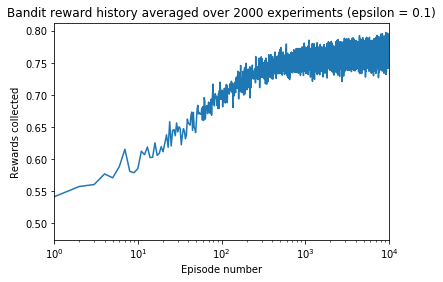

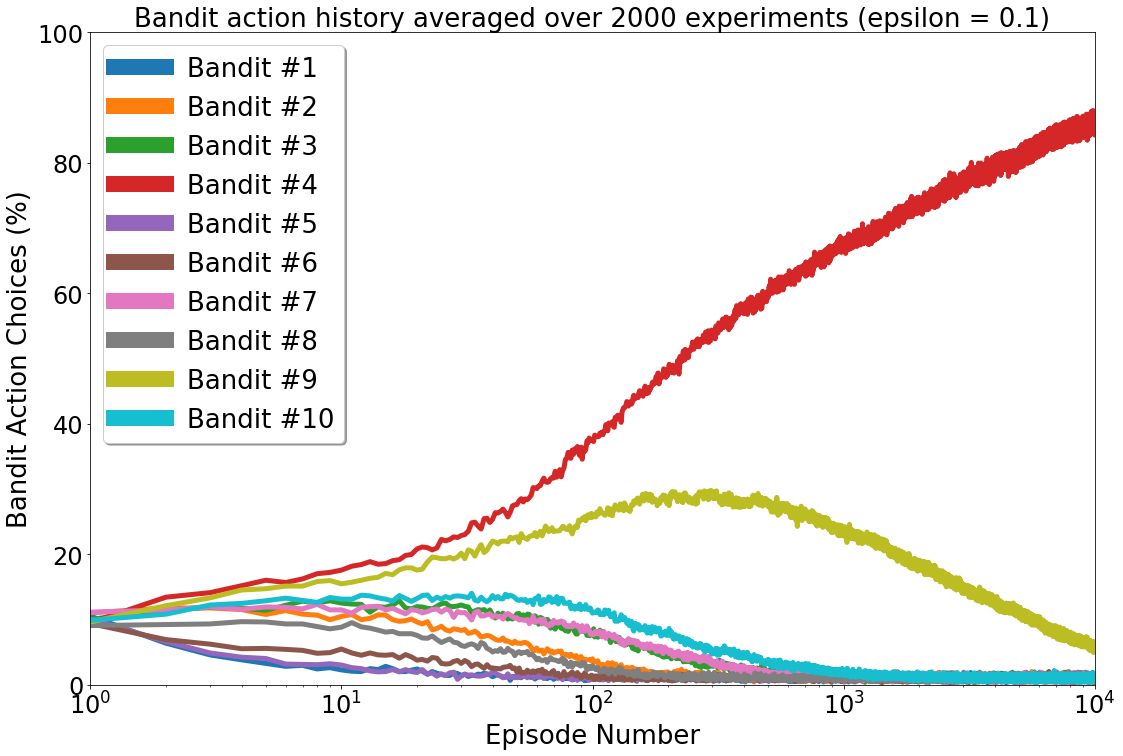

In [2]:
# Driver
if __name__ == "__main__":
    main()